# Capstone Project - NEED TO COME UP WITH TITLE

General Assembly passion project. Scrape or obtain data from resources online to develop a dataset to perform cleaning, EDA, and analysis on. Try to predict a model on common themes like: 

- Price
- If item is in category A or B
- Cluster and create groups

- Predict lowest amount a shoe will sell for? So people know what price to wait for before buying?

---

## DO AB TESTING ON IF ADIDAS INCREASED IN RARITY AFTER 2015

### Part 1 - Gathering the raw data

In [5]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from time import sleep, strftime
import ast
from os import listdir

pd.options.mode.chained_assignment = None

%matplotlib inline
%load_ext autotime

In [6]:
# Retrieving information from API in json format from StockX.com
result = requests.get('https://stockx.com/api/browse?page=1&category=152')
json_res = result.json()
result = requests.get('https://stockx.com/api/browse?page=2&category=152')
json_res = result.json()

time: 866 ms


In [7]:
# Functions to run for loop to scrape website.

def shoe_scraper(pages=50):
    '''Returns one dataframe of all results. And will save into a new file.'''
    
    # Have to run requests first to get appropriate column names
    req = requests.get('https://stockx.com/api/browse?page=1&category=152')
    json_req = req.json()
    df = pd.DataFrame([], columns=json_req['Products'][0].keys())

    for i in range(1,pages):
        try:
            html = 'https://stockx.com/api/browse?page=' + str(int(i)) + '&category=152'
            result = requests.get(html)
            json_res = result.json()
            df = pd.concat([df, pd.DataFrame(json_res['Products'])])
            sleep(0.5)
        except:
            break
    
    # Drop row duplicates
    df.drop_duplicates(['shortDescription', 'urlKey'], inplace=True) 
    
    # Function to save as csv file under today's day as raw (before dropping)
    def csv_maker(df):
        filename = 'StockX_' + strftime("%m%d%H")
        df.to_csv(path_or_buf='C:\\Users\\Chris\\Desktop\\dsi-atl-3\\project\\Capstone\\datasets\\' + filename, encoding='utf-8')
    csv_maker(df)    
    return df

time: 20 ms


In [8]:
def clean_df(busy_dataframe):
    '''Dropping columns that hold little to no information. Combining columns with relevant info.
    Then reset the index since we are getting repeated indices'''
    
    # Market DataFrame. If scraping, comes in ready form
    # If pulling from old data, dictionary comes in string form
    if isinstance(busy_dataframe.market.reset_index(drop=True)[0], str):
        market_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['market']])
    else:
        market_df = pd.DataFrame([row for row in busy_dataframe['market']])
        
    # Same, but for including link for images
    if isinstance(busy_dataframe.media.reset_index(drop=True)[0], str):
        media_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['media']])['thumbUrl']
    else:
        media_df = pd.DataFrame([row for row in busy_dataframe['media']])['imageUrl']
    
    # Combine dataframes and drop unnecessary columns
    cleaner_dataframe = busy_dataframe.join(market_df)
    cleaner_dataframe = cleaner_dataframe.join(media_df)
    
    cleanest_dataframe = cleaner_dataframe.drop(['breadcrumbs', 'childId', 'countryOfManufacture', 'type', 
        'uuid', 'dataType', 'doppelgangers', 'condition', 'description', 'hidden', 'ipoDate', 'productCategory', 
        'shoeSize', 'urlKey', 'charityCondition', 'releaseTime', 'shortDescription', 'media', '_highlightResult', 
        'market', '_tags', 'id', 'objectID', 'lastHighestBidTime', 'lastLowestAskTime', 'styleId', 'productId',
        'productUuid', 'skuUuid', 'updatedAt', 'traits', 'tickerSymbol', 'salesLastPeriod',
        'minimumBid', 'averageDeadstockPriceRank', 'deadstockSoldRank', 'pricePremium', 'pricePremiumRank',
        'salesThisPeriod', 'createdAt', 'lastSaleDate'], axis=1)
    
    # Reset the index, since we are getting repeated indices
    cleanest_dataframe.reset_index(drop=True, inplace=True)
    
    return cleanest_dataframe

time: 20 ms


In [9]:
## Web Scraper code
# scraped_shoe = shoe_scraper()

time: 51.4 s


In [10]:
def read_and_clean(path):
    '''Read a file path where datasets are stored. Cleans the dataframe by removing duplicates,
    removing first column (Unnamed: 0) to be ready for clean_df function.'''
    file_list = listdir(path)
    file_list.remove('dataio')
    
    # Make a list of all the dataframes
    parts_df = [pd.read_csv('../datasets/' + files) for files in file_list]
    
    # Make one dataframe, take out first column and drop duplicates based on 'urlkey'
    df = pd.concat(parts_df)
    df = df.iloc[:,1:]
    df.drop_duplicates(['uuid'], inplace=True)#, keep='last')
    
    # Clean Brand names
    df.brand = df.brand.map(lambda x: x.title())
    
    # Lastly, change 'nan' to np.nan.
    df = df.applymap(lambda x: np.nan if x=='nan' else x)

    return df

time: 12 ms


In [133]:
# Using functions defined above to read all previously downloaded data into one dataframe.
path = '../datasets/'

shoe = clean_df(read_and_clean(path))

time: 2.69 s


### Part 2 - Cleaning and Initial Analysis
Some initial cleaning and EDA will need to be done.
- Drop nulls
- Change time series into datetime if possible
- Check out the shape
- Drop the error value for the high bid > $20,000

**Make a metric for rarity: average Deadstock Price / retail Price**

In [134]:
# Some cleaning first. Take out null rows and change time data to date time
shoe.dropna(inplace=True)
shoe['releaseDate'] = pd.to_datetime(shoe.releaseDate).dt.date
shoe['year'] = shoe.year.map(lambda x: int(x))
shoe.shape

(2016, 24)

time: 20 ms


In [135]:
# New metric for rarity of shoe & a boolean for those above median
shoe['rarity'] = shoe.averageDeadstockPrice/shoe.retailPrice
shoe['rarity_bool'] = shoe.rarity.map(lambda x: 1 if x >= shoe.rarity.median() else 0)

# Since shoes retailed at $0 doesn't fit into the scope of the project, drop them.
infinity_ind = shoe[shoe.retailPrice==0].index
shoe.drop(infinity_ind, axis=0, inplace=True)
shoe.reset_index(inplace=True, drop=True)

# Most 'rare' shoes
shoe[['title', 'year', 'retailPrice', 'averageDeadstockPrice', 'highestBid', 'rarity']].sort_values('rarity', ascending=False).head()

,title,year,retailPrice,averageDeadstockPrice,highestBid,rarity
1720,Nike Dunk SB Low Supreme NY Black Cement (2002),2002,65.0,1388,1000,21.353846
1837,Nike SB Dunk High Momofuku,2017,110.0,1706,1336,15.509091
1636,Jordan 1 Retro Low OG Ice Blue,2017,140.0,1936,3037,13.828571
1838,Air Max 1 Air Max Day 3.26,2014,125.0,1706,1336,13.648000
1316,Nike Dunk SB High Tie Dye Black,2014,108.0,1447,1000,13.398148


time: 332 ms


(-5, 1500)

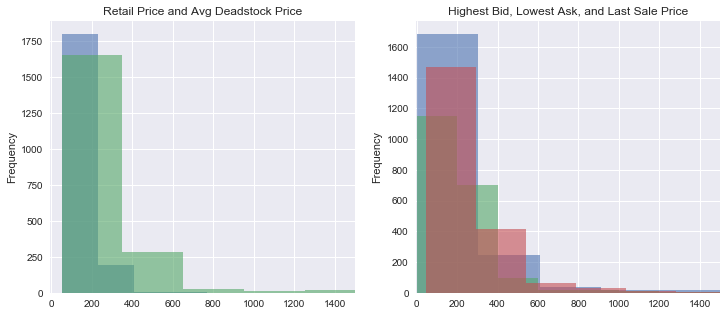

time: 475 ms


In [14]:
# Plots for general overview
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

shoe.retailPrice.plot(kind='hist', alpha=0.6, ax=ax1)
shoe.averageDeadstockPrice.plot(kind='hist', alpha=0.6, ax=ax1)
ax1.set_title('Retail Price and Avg Deadstock Price')
ax1.axes.set_xlim(-5, 1500)

shoe.highestBid.plot(kind='hist', alpha=0.6, ax=ax2)
shoe.lowestAsk.plot(kind='hist',alpha=0.6, ax=ax2)
shoe.lastSale.plot(kind='hist', alpha=0.6, ax=ax2)
ax2.set_title('Highest Bid, Lowest Ask, and Last Sale Price')
ax2.axes.set_xlim(-5,1500)

In [15]:
# A view of the most expensive bid on shoe.
shoe[shoe.highestBid > 2000][['shoe', 'colorway', 'lastSale', 'highestBid', 'averageDeadstockPrice', 'retailPrice']].sort_values('highestBid', ascending=False)

,shoe,colorway,lastSale,highestBid,averageDeadstockPrice,retailPrice
1634,Adidas Ultra Boost,Adidas-Ultra-Boost-Miami-Hurricanes,2515,3037,1936,180.0
1635,Nike Air Max 90,White/White,2515,3037,1936,160.0
1636,Jordan 1 Retro Low OG,Ice Blue/Vachetta Tan-White,2515,3037,1936,140.0
375,Jordan 1 Retro,Black/Sport Blue-White,1605,3000,1696,185.0
628,Adidas Yeezy Boost 750,Brown/Carbon White-Light Brown,2500,2125,3059,350.0
259,Adidas Yeezy Boost 350,Turtledove/Blue Grey-White,2100,2050,2223,200.0
353,Adidas NMD,EQT Yellow/EQT Yellow/FTWR White,2001,2050,828,240.0


time: 31 ms


In [16]:
# A view at the most highest retailed shoe. Strangely enough, it is not in the top 7 highest bid.
shoe[shoe.retailPrice == shoe.retailPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year']]

,shoe,colorway,name,retailPrice,year
1679,Air Yeezy 2,Gold/White,John Geiger x LASCO Golden Child,1850.0,2016


time: 15 ms


In [17]:
# A look at the highest average deadstock price
shoe[shoe.averageDeadstockPrice == shoe.averageDeadstockPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year', 'averageDeadstockPrice']]

,shoe,colorway,name,retailPrice,year,averageDeadstockPrice
628,Adidas Yeezy Boost 750,Brown/Carbon White-Light Brown,OG Light Brown,350.0,2015,3059


time: 32 ms


In [18]:
shoe.describe()

,retailPrice,year,absChangePercentage,annualHigh,annualLow,averageDeadstockPrice,changePercentage,changeValue,deadstockRangeHigh,deadstockRangeLow,deadstockSold,highestBid,lastSale,lowestAsk,salesLast72Hours,volatility,rarity,rarity_bool
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,173.284153,2014.749627,0.204662,442.361153,168.879285,280.868356,0.003104,-11.334327,305.359165,207.380030,219.593145,221.880278,256.352707,230.674118,5.102335,0.200717,1.729709,0.499752
std,75.135165,3.041774,0.232409,483.570437,133.642054,223.286504,0.309696,102.933731,268.221203,181.481158,430.692198,239.205455,222.050566,192.802060,22.357156,0.135516,1.435655,0.500124
min,50.000000,1985.000000,0.000000,50.000000,11.000000,50.000000,-0.666667,-1058.000000,55.000000,-18.000000,1.000000,0.000000,45.000000,0.000000,1.000000,0.000000,0.135135,0.000000
25%,140.000000,2014.000000,0.041860,250.000000,100.000000,174.000000,-0.157895,-41.000000,176.000000,111.000000,21.000000,110.000000,149.000000,140.000000,1.000000,0.123291,1.051429,0.000000
50%,160.000000,2016.000000,0.136364,325.000000,140.000000,228.000000,0.000000,0.000000,239.000000,167.000000,76.000000,176.000000,200.000000,185.000000,2.000000,0.177077,1.392857,0.000000
75%,190.000000,2017.000000,0.300926,471.000000,195.000000,313.000000,0.103306,21.000000,350.000000,247.000000,228.000000,250.000000,300.000000,250.000000,4.000000,0.250277,1.905000,1.000000
max,1850.000000,2017.000000,2.529412,8550.000000,1715.000000,3059.000000,2.529412,549.000000,3693.000000,1900.000000,5579.000000,3037.000000,2515.000000,2000.000000,916.000000,1.362362,21.353846,1.000000


time: 78 ms


**Descriptions of some columns**

- deadstockRangeHigh = highest price of deadstock within the last 12 mo.
- deadstockRangeLow = lowest price of deadstock within the last 12 mo.
- highestBid = highest price someone is bidding, or willing to pay
- lowestAsk = lowest price someone is currently asking for, or selling
- rarity = averageDeadstockPrice / retailPrice
- lastSale = Last price product was sold for sourced from ebay, twitter, etc.
---

### Part 3 - Subset data with top 3 brands and perform EDA
Scale the dataframe down so that not too many outside brands are taking the focus away from the main goal of the project.

In [171]:
# Concerned with only the top brands
topshoes = shoe[(shoe.brand=='Adidas')|(shoe.brand=='Nike')|(shoe.brand=='Jordan')]
topshoes.reset_index(drop=True, inplace=True)
topshoes.shape

(1863, 26)

time: 12 ms


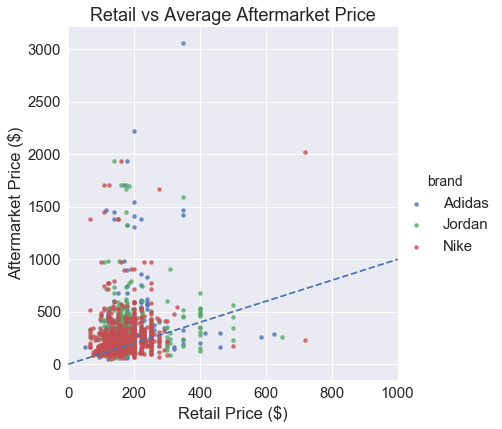

time: 331 ms


In [172]:
# See a 1-to-1 linear line for retail Price vs Aftermarket price
sns.set(font_scale=1.5)
sns.lmplot(x='retailPrice', y ='averageDeadstockPrice', data=topshoes, hue='brand', fit_reg=False, size=6,
          scatter_kws={"s": 20})
plt.plot(np.linspace(0,2000,2000), np.linspace(0,2000,2000), linestyle='--')
plt.xlim([0,1000])
plt.title('Retail vs Average Aftermarket Price')
plt.xlabel('Retail Price ($)')
plt.ylabel('Aftermarket Price ($)')
plt.show()

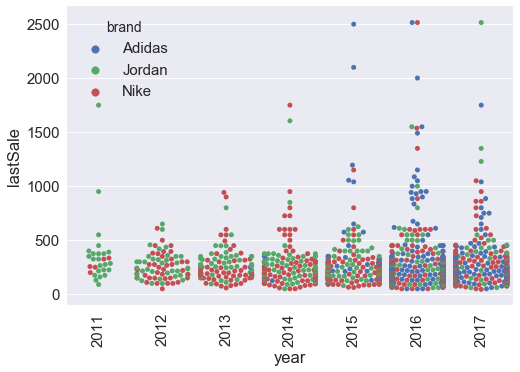

time: 34.7 s


In [173]:
sns.swarmplot(x='year', y='lastSale', data=topshoes[topshoes.year>2010], hue='brand')
plt.xticks(rotation=90)
plt.show()

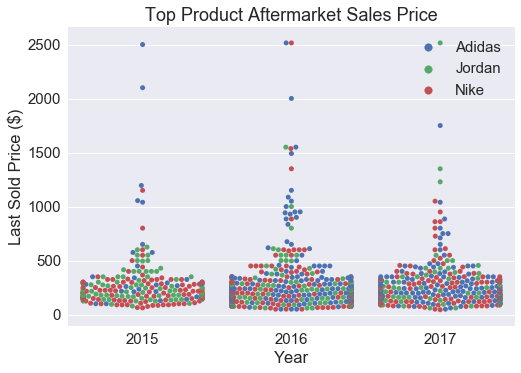

time: 36.1 s


In [22]:
# Adidas didn't really come into the market until 2015. Let's look more closely
sns.swarmplot(x='year', y='lastSale', data=tops[topshoes.year>2014], hue='brand')
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('Last Sold Price ($)')
plt.title('Top Product Aftermarket Sales Price')
plt.show()

# After some market research, Adidas came into the sneakerhead culture because of two products: the Adidas Boost and the Adidas Yeezy's. Nike was first partnered with Kanye West for making a collaborative shoe. But after his contract ended, Mr. West changed sides to Adidas, who previously was widely known for their athletic shoes (for soccer and football) rather than collectible sneakers. DO I WANT TO INCORPORATE THIS FINDING AND DO SOME DATA ANALYSIS ON IT? A/B TESTING?

---

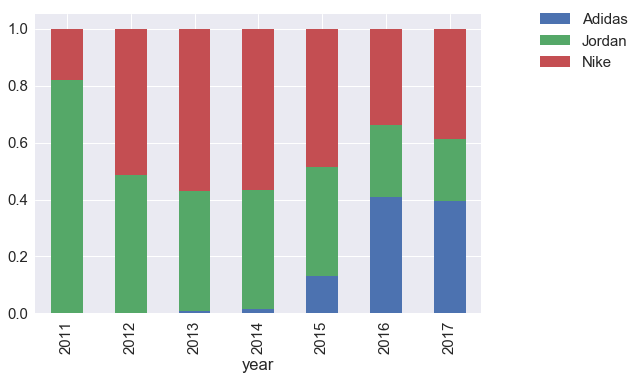

time: 243 ms


In [130]:
# Did Adidas increase market share (on StockX) in pure number of listings?
sub_tops = topshoes[topshoes.year>2010].groupby(['year', 'brand'])['brand'].count().unstack().fillna(0)
sub_tops = sub_tops.T
sub_tops = sub_tops.div(sub_tops.sum())
sub_tops = sub_tops.T

sub_tops.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

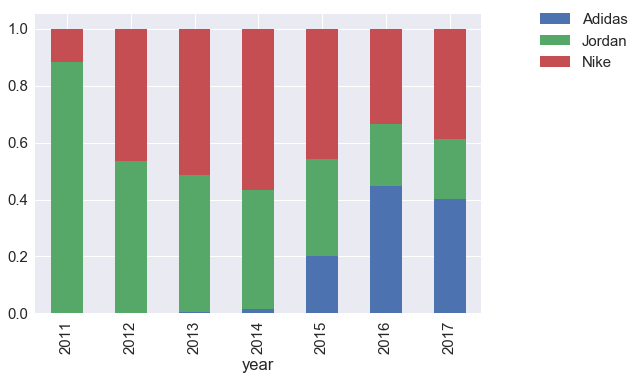

time: 256 ms


In [175]:
# Did Adidas increase in terms of sneakerhead influence, measured by sum of rarity?
sub_tops = topshoes[topshoes.year>2010].groupby(['year', 'brand'])['rarity'].sum().unstack().fillna(0)
sub_tops = sub_tops.T
sub_tops = sub_tops.div(sub_tops.sum())
sub_tops = sub_tops.T

sub_tops.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

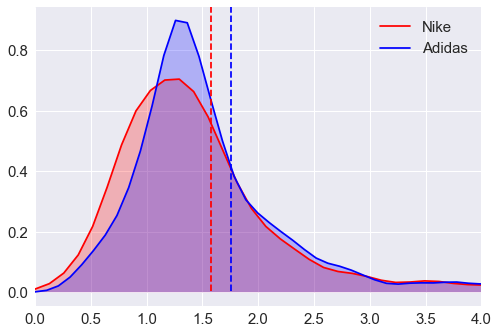

time: 228 ms


In [176]:
import scipy.stats as stats
#H0 - The average rarity of Adidas is the same as the average rarity of Nike since 2015
#H1 - The average rarity of Adidas is NOT the same as the average rarity of Nike since 2015
# threshold -> 5%

nike_rarity = topshoes[(topshoes.year>=2015) & (topshoes.brand=='Nike')].rarity
adidas_rarity = topshoes[(topshoes.year>=2015) & (topshoes.brand=='Adidas')].rarity

sns.kdeplot(nike_rarity, color='red', shade=True, legend=False)
sns.kdeplot(adidas_rarity, color='blue', shade=True, legend=False)
plt.axvline(x=nike_rarity.mean(), ymin=0.05, c='r', ls='--')
plt.axvline(x=adidas_rarity.mean(), ymin=0.05, c='b', ls='--')
plt.xlim([0,4])
plt.legend(['Nike', 'Adidas']);

In [174]:
stats.ttest_ind(nike_rarity, adidas_rarity)
# p < 0.05. So we reject the null hypothesis that the averages are the same. They are
# in fact different. Statistically, Adidas has a higher average rarity.

Ttest_indResult(statistic=-2.1149211135360542, pvalue=0.034693560028138871)

time: 4 ms


In [221]:
# import statsmodels.api as sm
# from sklearn.preprocessing import StandardScaler

# ab_sub = topshoes[(topshoes.rarity_bool == 1) & (topshoes.year >=2015) & ((topshoes.brand=='Adidas') | (topshoes.brand=='Nike'))].copy()
# ab_sub_unstack = ab_sub.groupby(['year','brand']).size().unstack()
# ab_sub_unstack.reset_index(inplace=True)

# X = ab_sub_unstack.year.values
# ss = StandardScaler()
# Xs = ss.fit_transform(X.reshape(-1,1))
# # manually add the intercept column:
# Xs1 = np.concatenate([Xs, np.ones((Xs.shape[0], 1))], axis=1)
# y = ab_sub_unstack.Adidas

# model = sm.OLS(y, X)
# model = model.fit()
# model.summary()

# # stats model OLR p values of coeffecients using summary
# # determine if 2015-2017 nikes growth and adidas growth are different

time: 4 ms


## Part 4 - Natural Language Processing & Modeling


In [225]:
# NLP
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer

# Metrics & Preprocessing
from sklearn.metrics import accuracy_score, completeness_score, silhouette_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

time: 4 ms


In [226]:
# Going to make a copy of the dataframe in case any changes are made later on
tops = topshoes.copy()

# Maybe the colorway is an indicator of averageDeadstockPrice
snow = SnowballStemmer('english')

# placeholder = pd.Series('Colorway_token')
placeholder = pd.Series(tops.colorway.apply(lambda x: x.replace("/"," ").replace('-',' ').split(" ")))

tops['colorway_token'] = placeholder.apply(lambda x: " ".join([snow.stem(y) for y in x]))

time: 216 ms


In [227]:
baseline = max(1 - tops.rarity_bool.mean(), tops.rarity_bool.mean())
print baseline

0.506172839506
time: 4 ms


In [228]:
# Make X, y, and train/test split
X = tops.drop('rarity_bool', axis=1)
y = tops.rarity_bool
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

time: 8 ms


In [229]:
# Going to try several vectorizers and models. Better to write a function that will do this in one step.
def tokenize_test(text, vect, model, target='rarity_bool', 
                  X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    '''Arguments are text, vect, model, target (in strings), X_train, X_test, y_train, y_test.
    Used to find the accuracy of the rarity.'''
    X = tops[text]
    y = tops[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)
    X_train_dtm = vect.fit_transform(X_train)
    
    X_test_dtm = vect.transform(X_test)
    model.fit(X_train_dtm, y_train)
    y_pred_class = model.predict(X_test_dtm)
    return accuracy_score(y_test, y_pred_class)

# Making a function to make a dataframe for the accuracy results of tokenize_test
def accuracy_df_maker(models, vectors, texts, target):
    '''models and vectors are dictionarys with key as the label and value as the object.
    texts is a list of features to test on. Returns a sorted dataframe with accuracy scores
    of every model, vectorizer, and feature combintion'''
    Accuracy_scores = []
    for model_k, model_v in models.items():
        for vect_k, vect_v in vectors.items():
            for text in texts:
                Accuracy_scores.append((model_k, vect_k, text, tokenize_test(text, vect_v, model_v, target)))
    
    df = pd.DataFrame(Accuracy_scores, columns=['Model', 'Vectorizer', 'Feature', 'Accuracy_score'])
    return df.sort_values('Accuracy_score', ascending=False).reset_index(drop=True)

time: 24 ms


In [230]:
# Parameter set up
ng = (2,5)
cvec, hvec, tvec = CountVectorizer(ngram_range=ng), HashingVectorizer(ngram_range=ng), TfidfVectorizer(ngram_range=ng)

models = {'SVC':SVC(), 'Log':LogisticRegression(), 'Bernoulli':BernoulliNB(), 'KNN':KNeighborsClassifier()}
vectors = {'CVEC':cvec, 'HVEC':hvec, 'TVEC': tvec}
texts = ['colorway_token', 'category', 'title', 'name']

# Function run
nlp = accuracy_df_maker(models, vectors, texts, 'rarity_bool')
print 'Baseline: ', baseline
nlp.head()

Baseline:  0.506172839506


,Model,Vectorizer,Feature,Accuracy_score
0,Log,TVEC,title,0.621984
1,Log,TVEC,category,0.611260
2,Bernoulli,CVEC,title,0.595174
3,Bernoulli,TVEC,title,0.595174
4,Bernoulli,TVEC,category,0.592493


time: 5.65 s


In [231]:
# Separate functions because random forest with hashing takes more than 3 minutes with worse results.
# Same with Multinomial. Combining all into one dataframe, nlp_df

models2 = {'Random Forest':RandomForestClassifier(), 'Multinomial':MultinomialNB()}
vectors2 = {'CVEC':cvec, 'TVEC':tvec}

nlp_add = accuracy_df_maker(models2, vectors2, texts, target='rarity_bool')
nlp_df = pd.concat([nlp, nlp_add]).sort_values('Accuracy_score', ascending=False).reset_index(drop=True).copy()

time: 2.84 s


In [232]:
# Trying bagging and boosting. Again hashing takes too long and doesn't increase score by much. So taking out.

# Model Set up
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
bagger = BaggingClassifier(dtree, max_samples=0.5, max_features=0.5)
booster = AdaBoostClassifier(dtree, n_estimators=50, learning_rate=1.0)

# Parameter setup
models3 = {'Bagger':bagger, 'Booster':booster}

bag_add = accuracy_df_maker(models3, vectors2, texts, target='rarity_bool')
df = pd.concat([nlp_df, bag_add]).sort_values('Accuracy_score', ascending=False).reset_index(drop=True).copy()

time: 48.4 s


In [233]:
print 'Baseline: ', baseline
df[df.Accuracy_score > baseline*1.175]

Baseline:  0.506172839506


,Model,Vectorizer,Feature,Accuracy_score
0,Log,TVEC,title,0.621984
1,Multinomial,TVEC,title,0.613941
2,Log,TVEC,category,0.611260
3,Booster,CVEC,title,0.608579
4,Multinomial,TVEC,category,0.595174
5,Bernoulli,CVEC,title,0.595174
6,Bernoulli,TVEC,title,0.595174


time: 16 ms


In [234]:
# Trying to finetune models to achieve better accuracy scores
from sklearn.model_selection import GridSearchCV
X = tops.title
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

X_train_dtm = tvec.fit_transform(X_train)
X_test_dtm = tvec.transform(X_test)

log_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}
lr_gridsearch = GridSearchCV(LogisticRegression(), log_params, cv=5, verbose=1)
lr_gridsearch.fit(X_train_dtm, y_train)
lr_dict = lr_gridsearch.best_params_
print lr_dict

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'penalty': 'l2', 'C': 0.35111917342151272, 'solver': 'liblinear'}
time: 5.53 s


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.3s finished


In [235]:
logreg = LogisticRegression(C=lr_dict['C'], penalty=lr_dict['penalty'], solver=lr_dict['solver'])
logreg.fit(X_train_dtm, y_train)
print accuracy_score(y_test, logreg.predict(X_test_dtm)), df.iloc[0,-1]

0.630026809651 0.621983914209
time: 16 ms


In [236]:
# Trying to do PCA on these word vectors to achieve better score:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
svd_words = svd.fit_transform(X_train_dtm)

logreg.fit(svd_words, y_train)
svd_pred_df = pd.DataFrame(logreg.predict(svd.transform(X_test_dtm)))

print accuracy_score(y_test, svd_pred_df.iloc[:,:6])
print 'Due to randomness, results show values from 0.55 to 0.62, which would be nearly the best model'

0.576407506702
Due to randomness, results show values from 0.55 to 0.62, which would be nearly the best model
time: 220 ms


## Part 5 - Clustering

In [237]:
cv_color = CountVectorizer(max_features=20, stop_words=['core'], ngram_range=(1,2))
all_colors = cv_color.fit_transform(tops.colorway_token)
color_df = pd.DataFrame(all_colors.todense(), columns=cv_color.get_feature_names())

time: 56 ms


In [238]:
#### Dummy variables ####
# Change brand to 0, 1, 2
# Change category based on words [Yeezy, NMD, Air Jordan, Ultra Boost, Adidas/Nike Other, 
# Air Max, Iniki, Air Force, Foamposite, LeBron, KD, Nike SB, Kobe, Nike Basketball/Other]
# Change colorway based on color spectrum colors (color_df.columns)

tops.brand = tops.brand.astype('category').cat.codes

category_list = ['Yeezy', 'NMD', 'Air Jordan', 'Ultra Boost', 'adidas Other', 'Nike Other', 'Air Max',
                'Iniki', 'Air Force', 'Foamposite', 'LeBron', 'KD', 'Nike SB', 'Kobe', 'Nike Basketball']
for cat in category_list:
    tops[cat] = tops.category.map(lambda x: 1 if cat.lower() in x.lower() else 0)
    
color_list = list(color_df.columns)    
for color in color_list:
    tops[color] = tops.colorway_token.map(lambda x: 1 if color.lower() in x.lower() else 0)
    
# Change all spaces to _ in column names
tops.columns = tops.columns.str.replace(' ','_')

time: 140 ms


---

# Do clustering with colors/category/colors&category

---

In [239]:
col_list = tops.loc[:,'Yeezy':].columns
mat_string = ' + '.join(col_list)
mat_string

u'Yeezy + NMD + Air_Jordan + Ultra_Boost + adidas_Other + Nike_Other + Air_Max + Iniki + Air_Force + Foamposite + LeBron + KD + Nike_SB + Kobe + Nike_Basketball + black + black_black + black_white + blue + dark + gold + green + grey + light + metal + metal_gold + metal_silver + red + silver + univers + univers_red + varsiti + varsiti_red + white + white_black'

time: 12 ms


In [240]:
import patsy
other_var = '''retailPrice + absChangePercentage + annualHigh + annualLow + averageDeadstockPrice + 
deadstockRangeHigh + deadstockRangeLow + brand + deadstockSold + highestBid + lastSale + lowestAsk + 
salesLast72Hours + volatility + rarity - 1'''
matrix_string = 'category ~ ' + other_var + ' + ' + mat_string

y_cluster, X_cluster = patsy.dmatrices(matrix_string, tops)

time: 100 ms


In [241]:
from sklearn.cluster import DBSCAN, KMeans
ss = StandardScaler()
Xs = ss.fit_transform(X_cluster)

db = DBSCAN(eps=5, min_samples=20)
db.fit(Xs)

print pd.Series(db.labels_).unique()
print 'Not in a class %:', list(db.labels_).count(-1)/float(len(tops)) * 100
print 'In first class %:', list(db.labels_).count(0)/float(len(tops)) * 100
print 'In remaining classes %:', 100 - (list(db.labels_).count(-1)/float(len(tops)) * 100 + list(db.labels_).count(0)/float(len(tops)) * 100)
print '------------------------'
print 'Last label count:', list(db.labels_).count(pd.Series(db.labels_).unique()[-1])

tops['cluster_label'] = pd.Series(db.labels_)

[-1  0  1  2  3  6  4  5  9  7  8]
Not in a class %: 24.154589372
In first class %: 55.0724637681
In remaining classes %: 20.7729468599
------------------------
Last label count: 41
time: 726 ms


In [242]:
# KMeans
km = KMeans(n_clusters=6, random_state=42)
km.fit(Xs)
pd.Series(km.labels_).unique()

print pd.Series(km.labels_).value_counts()

tops['cluster_label'] = pd.Series(km.labels_)

3    944
2    440
1    201
5    119
4    109
0     50
dtype: int64
time: 156 ms


In [243]:
tops[tops.cluster_label == 0].describe()

,brand,retailPrice,year,absChangePercentage,annualHigh,annualLow,averageDeadstockPrice,changePercentage,changeValue,deadstockRangeHigh,...,metal_silver,red,silver,univers,univers_red,varsiti,varsiti_red,white,white_black,cluster_label
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0
mean,0.920000,196.960000,2014.24000,0.219455,2405.920000,806.200000,1350.560,-0.027550,-119.620000,1536.580000,...,0.020000,0.200000,0.020000,0.020000,0.020000,0.080000,0.060000,0.380000,0.020000,0.0
std,0.853325,100.351619,3.66205,0.191647,1480.500423,262.527355,467.634,0.291715,434.109875,630.507573,...,0.141421,0.404061,0.141421,0.141421,0.141421,0.274048,0.239898,0.490314,0.141421,0.0
min,0.000000,65.000000,2001.00000,0.000000,1027.000000,350.000000,624.000,-0.529000,-1058.000000,764.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,150.000000,2014.00000,0.047910,1542.000000,612.500000,972.000,-0.223627,-350.000000,1158.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,177.500000,2016.00000,0.150901,2000.000000,813.000000,1388.000,0.012658,10.000000,1298.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2.000000,200.000000,2016.00000,0.373351,2700.000000,948.000000,1669.000,0.109787,195.250000,1762.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,2.000000,720.000000,2017.00000,0.548452,8550.000000,1715.000000,3059.000,0.548452,549.000000,3693.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


time: 136 ms


## Part 6 - Predicting Rarity (regression and classification)

In [303]:
# Now have a bunch more variables. Would be a good idea to do PCA on the features to avoid multicollinearity.
num_df = tops.drop(['cluster_label','retailPrice', 'averageDeadstockPrice', 'releaseDate', 
                    'category', 'colorway', 'name', 'shoe', 'title', 'thumbUrl', 
                    'colorway_token', 'deadstockRangeHigh', 'deadstockRangeLow', 'rarity',
                   'rarity_bool'], 
                    axis=1).copy()

# Make another dataframe that doesn't include any colors or names to see if all those dummy variable creation mattered.
no_extra_df = num_df.loc[:,:'volatility'].copy()

time: 12 ms


In [318]:
def setup(dropped_col=False, regression=True):
    if dropped_col:
        X = no_extra_df.drop(dropped_col,axis=1)
    else:
        X = no_extra_df
    if regression:
        y = tops.rarity
    else:
        y = tops.rarity_bool
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=42)
    Xs = ss.fit_transform(X_train)
    Xst = ss.transform(X_test)
    
    return Xs, Xst, y_train, y_test

time: 12 ms


In [321]:
from sklearn.pipeline import Pipeline, FeatureUnion

Xs, Xst, y_train, y_test = setup()

combined_features = FeatureUnion([('ss',StandardScaler()), ('pca', PCA())])

lin_pipeline = Pipeline([('features', combined_features), ('linreg',LinearRegression())])

pipe_param = {
    'features__pca__n_components':np.arange(len(X.columns))
}

gs_ = GridSearchCV(lin_pipeline,param_grid=pipe_param)
gs_.fit(Xs, y_train)
gs_.best_params_

{'features__pca__n_components': 6}

time: 778 ms


In [152]:
def model_maker(X, y, N_components, model):
    '''Prints out cross-val score of training data and R^2 score of test data.
    Can use PCA dependent on N_components and choose either linear or logistic regression.'''
    # Model input set up
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=42)
    Xs = ss.fit_transform(X_train)
    Xst = ss.transform(X_test)
    
    # Using PCA
    if N_components > 0:
        pca = PCA(n_components=N_components)
        pca_train = pca.fit_transform(Xs)
        # For linear or logistic regression (two labels only)
        if len(y.unique()) >= 2:
            train_score = np.mean(cross_val_score(model, pca_train, y_train, cv=5))
            print 'Cross-val score on training:', train_score
            model.fit(pca_train, y_train)
            pca_test = pd.DataFrame(pca.transform(Xst))
            test_score = model.score(pca_test,y_test)
            print 'R^2 (RSS) on test:', test_score
        else:
            print 'Choose a target that is either boolean or for linear regression'
    # Not using PCA
    elif N_components == None:
        if len(y.unique()) >= 2:
            train_score = np.mean(cross_val_score(model, Xs, y_train, cv=5))
            print 'Cross-val score on training:', train_score
            model.fit(Xs, y_train)
            test_score = model.score(Xst, y_test)
            print 'R^2 (RSS) on test:', test_score
        else:
            print 'Choose a target that is either boolean or for linear regression'
    # Catch for weird inputs for N_components
    else:
        print 'Choose a correct N_components'

    return train_score, test_score

time: 28 ms


In [268]:
# PCA for linear regression
X = no_extra_df.drop(['rarity', 'rarity_bool'], axis=1)
y = num_df.rarity

linreg = LinearRegression()
model_maker(X,y,6, linreg);

Cross-val score on training: 0.712551006979
R^2 (RSS) on test: 0.694610182585
time: 28 ms


In [157]:
# PCA for classification
X = no_extra_df.drop(['rarity', 'rarity_bool'], axis=1)
y = num_df.rarity_bool
logreg = LogisticRegression()
model_maker(X,y,2,logreg);

Cross-val score on training: 0.790604412285
R^2 (RSS) on test: 0.801608579088
time: 40 ms


In [158]:
# Non-PCA logistic regression
X = no_extra_df.drop(['rarity', 'rarity_bool'], axis=1)
y = num_df.rarity_bool
logr = LogisticRegression()
model_maker(X,y,0,logr);

Cross-val score on training: 0.796665003231
R^2 (RSS) on test: 0.817694369973
time: 52 ms


In [159]:
# Getting only the top coefficients from the logistic regression
coef_df = pd.DataFrame(zip(no_extra_df.drop(['rarity','rarity_bool'],axis=1).columns, logr.coef_[0]), columns=['Feature', 'Coefficients'])
coef_df['abs'] = abs(coef_df.Coefficients).copy()
coef_df = coef_df.sort_values('abs', ascending=False).reset_index(drop=True)
coef_df

,Feature,Coefficients,abs
0,lastSale,2.244578,2.244578
1,annualLow,0.951661,0.951661
2,lowestAsk,0.865225,0.865225
3,changeValue,-0.817723,0.817723
4,highestBid,0.501920,0.501920
5,year,-0.352561,0.352561
6,annualHigh,0.350823,0.350823
7,changePercentage,0.345506,0.345506
8,deadstockSold,0.231653,0.231653
9,volatility,0.182764,0.182764


time: 20 ms


In [160]:
# Using only the top few coefficients as features
X = no_extra_df.drop(['rarity', 'rarity_bool', 'lastSale', 'lowestAsk', 'highestBid'], axis=1)
y = no_extra_df.lastSale
lr = LinearRegression()
model_maker(X,y,0, lr)
lr_coef_df = pd.DataFrame(zip(num_df.drop(['rarity', 'rarity_bool','lastSale', 'lowestAsk', 'highestBid'], axis=1).columns, lr.coef_), columns=['Feature', 'Coefficients'])

Cross-val score on training: 0.805582123789
R^2 (RSS) on test: 0.878481106055
time: 28 ms


In [161]:
lr_coef_df['abs'] = abs(lr_coef_df.Coefficients).copy()
lr_coef_df.sort_values('abs', ascending=False, inplace=True)
lr_coef_df.reset_index(drop=True)

,Feature,Coefficients,abs
0,annualLow,181.544153,181.544153
1,changeValue,52.858240,52.858240
2,annualHigh,31.757921,31.757921
3,absChangePercentage,10.583283,10.583283
4,changePercentage,-7.814005,7.814005
5,salesLast72Hours,-7.228016,7.228016
6,volatility,-5.622070,5.622070
7,deadstockSold,4.326747,4.326747
8,brand,-3.366789,3.366789
9,year,-1.368135,1.368135


time: 20 ms


## Part 7 - Image Processing

The code below is for image processing using Keras and Tensorflow. Unfortunately, these libraries don't play nicely with Windows. As a result, a virtual machine was used in another notebook. The forked repository is an extension of the deep learning repository by github user *[nirmalyaghosh](https://github.com/nirmalyaghosh/deep-learning-vm)*.

Imaging code adapted from *[source1](https://pythonprogramming.net/automated-image-thresholding-python/?completed=/thresholding-python-function/)* and *[source2](http://pillow.readthedocs.io/en/3.4.x/reference/Image.html)*. Finally, pickling code was sourced from *[stackoverflow](https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict)*.

The code to transfer data is below in markdown mode for reading convenience. The rest of the code can be found at *[my github](https://github.com/chrisk447/deep-learning-vm/blob/master/notebooks/Capstone%20Image%20Processing.ipynb)*.

    # only gathering images for those that have images. (As of 7/7/2017)
    import urllib3
    from PIL import Image
    import io

    tops_with_pics = tops[tops.thumbUrl != '']
    tops_with_pics.reset_index(drop=True, inplace=True)

    # Interpreting the image as data and preparing it to be pickled.
    pickled_array = []
    counter = 0
    for shoe_num in range(len(tops_with_pics)):
        fd = urllib.urlopen(tops_with_pics.thumbUrl[shoe_num])
        image_file = io.BytesIO(fd.read())
        i = Image.open(image_file).convert('RGB')
        iar = np.asarray(i)
        iar.setflags(write=1)

        pickled_array.append(iar)
        sleep(0.5)
        image_file.close()
        fd.close()

    # Pickling the feature data into the deep learning repository
    with open('../../../keras/deep-learning-vm/notebooks/shoenumbers.pickle', 'wb') as handle:
        pickle.dump(pickled_array, handle, protocol=2)

    # Pickling the target data into the deep learning repository
    with open('../../../keras/deep-learning-vm/notebooks/targetvars.pickle', 'wb') as handle2:
        pickle.dump(tops_with_pics.rarity_bool.values, handle2, protocol=2)

--- 
# Conclusion
The most important features that can be found at release date for determining if a shoe is going to be rare is the year, lowestAsk, highestBid, and lastSale. The most important of those features is lastSale, the last price the shoe was sold for on all portals. Used PCA because some features are closely related (annualLow and annualHigh, etc.)

Performing a linear regression for lastSale, it's determined mostly by annualLow, changeValue, and annualHigh. What's interesting is that brand does not determine last sale price nor rarity. All 3 brands have just as much chance to be rare, signifying Adidas' rise in sneakerhead culture.

# changeValue is how much last sale changed by

**Next step is, now that I have PC for rarity on a continuous scale, what can I do with it?**

---